In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from matlab_functions import stencil2prec, parula_map
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from sksparse.cholmod import cholesky as cholesky_sparse
from scipy.sparse.linalg import spsolve

In [85]:
#kappa adjusts the correlation to neighbouring pixels.
#the higher the kappa the higer is the contribution
#from its own mean, the lower the more the pixel
#is affected by the values of the neighbouring pixels.
#Thus, since the neighbouring pixels are correlated
#by their neighbours, the correlation traverserses the image
#like a wave.
kappa = 1
m1 = 215
m2 = 126
# q represents a stencil for a precision matrix Q where
#a pixel ij is only affected by its 4 neighbours with sharing sides.
#Since the neighbours have values of -1 they all contribute the same
#to the concerned pixel

q1 = kappa**2 * np.array([[0, 0, 0], [0, 1, 0], [0, 0, 0]]) + np.array([[0, -1, -10], [-1, 24, -1], [-10, -1, 0]])
q2 = np.array([[-10, -0.1, 0], [-0.1, 20.4+kappa**2, -0.1], [0, -0.1, -10]])
q3 = np.array([[0, -1, -10], [-1, 24+kappa**2, -1], [-10, -1, 0]])
q4 = np.array([[-1, -5, -1], [-5, 24+kappa**2, -5], [-1, -5, -1]])
q5 = q2 + q3
# stencil2prec returns a sparse matrix

Q = stencil2prec([m1, m2], q1)
print(Q.shape)
# multiply together Q to get a broader neighbourhood influence.
#Q = Q @ Q

# covariance between the middle pixel and all other pixels:
v = np.zeros(m1*m2)
v[(m1*m2)//2 + 90] = 1

c = spsolve(Q, v)

(27090, 27090)


In [86]:
# Simulation
# chol(Q) performs minimum reordering of the sparse matrix Q via the amd
# function automatically and returns the permutation preordering in P. I
# flag is zero then Q is symmetric positive definite (SPD) and R is an
# upper triangular matrix satisfying R'*R = P'*S*P

factor = cholesky_sparse(Q)

v = np.zeros((m1*m2))
v[round((m1*m2)/2) - 300] = 1
x = factor(np.random.randn((m1*m2)))

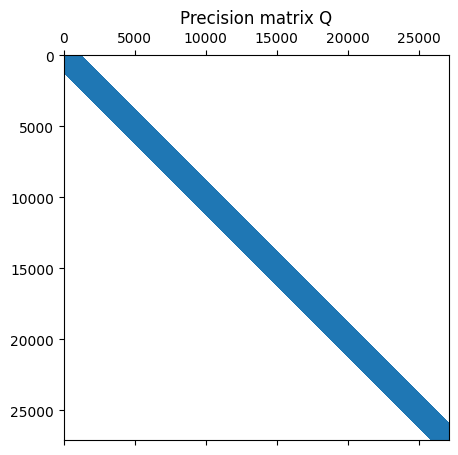

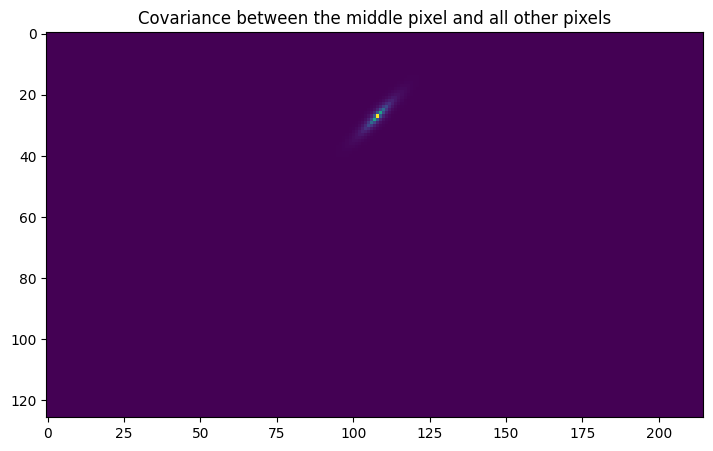

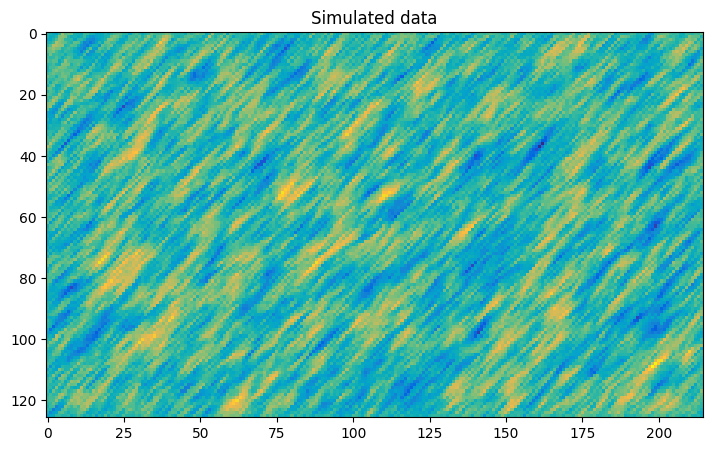

In [87]:

plt.spy(Q)
plt.title("Precision matrix Q")
plt.show()

plt.imshow(c.reshape([m1, m2], order='F'))
plt.title("Covariance between the middle pixel and all other pixels")
plt.show()

plt.imshow(x.reshape([m1, m2], order='F'), cmap=parula_map)
plt.title("Simulated data")
plt.show()

In [88]:

N = 15000
ind = np.random.permutation((m1*m2))
ind_obs_full = ind[:N]
ind_obs = ind_obs_full[:10000]
ind_mis = ind[N:]
x_obs = x[ind_obs]
x_mis = x[ind_mis]

Q_m = Q[ind_mis, :][:, ind_mis]
Q_mo = Q[ind_mis, :][:, ind_obs]

mu_m = 0
mu_o = 0
mu_m_o = 0 - spsolve(Q_m, Q_mo @ (x_obs - mu_o))

x_rec = np.zeros((m1*m2))
x_rec[ind_obs_full] = x[ind_obs_full]
x_rec[ind_mis] = mu_m_o

x_seen = np.zeros((m1*m2)) - 1000
x_seen[ind_obs_full] = x[ind_obs_full]


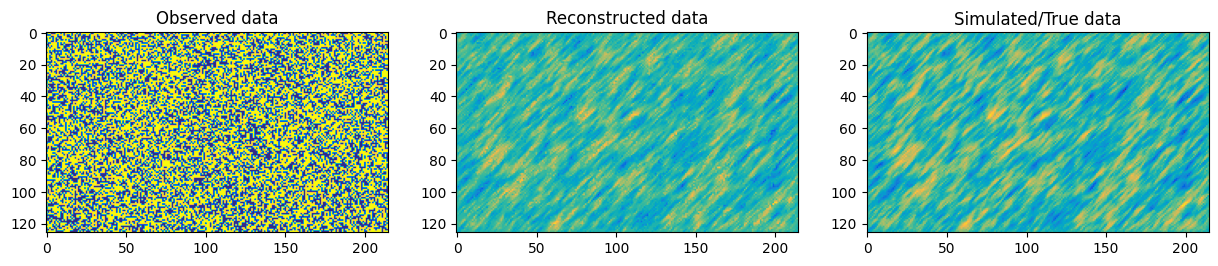

In [90]:

# make figure bigger
plt.rcParams['figure.figsize'] = [15, 5]
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

ax1.imshow(x_seen.reshape([m1, m2], order='F'), cmap=parula_map)
ax1.set_title("Observed data")

ax2.imshow(x_rec.reshape([m1, m2], order='F'), cmap=parula_map)
ax2.set_title("Reconstructed data")

ax3.imshow(x.reshape([m1, m2], order='F'), cmap=parula_map)
ax3.set_title("Simulated/True data")
plt.show()